<a href="https://colab.research.google.com/github/HHllmn/INT2Flowers102/blob/main/Flowers102NetworkFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import *
from torchvision.transforms import ToTensor, Lambda
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
preimage_size = (300,300)
image_size = (200, 200)
# Initial transforms for training dataset
training_initial_tranforms = transforms.Compose([transforms.Resize(preimage_size), transforms.ToTensor()])

## Displays 5 resized images from the training set

Feature batch shape: torch.Size([32, 3, 300, 300])
Labels batch shape: torch.Size([32])


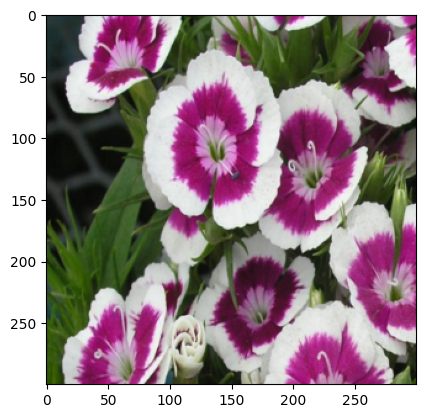

Label: 29
Feature batch shape: torch.Size([32, 3, 300, 300])
Labels batch shape: torch.Size([32])


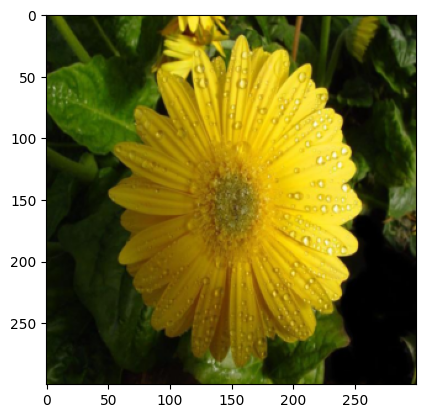

Label: 40
Feature batch shape: torch.Size([32, 3, 300, 300])
Labels batch shape: torch.Size([32])


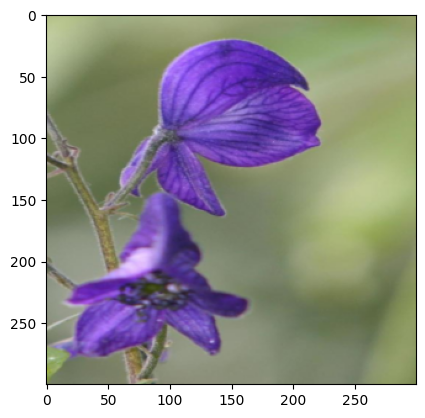

Label: 8
Feature batch shape: torch.Size([32, 3, 300, 300])
Labels batch shape: torch.Size([32])


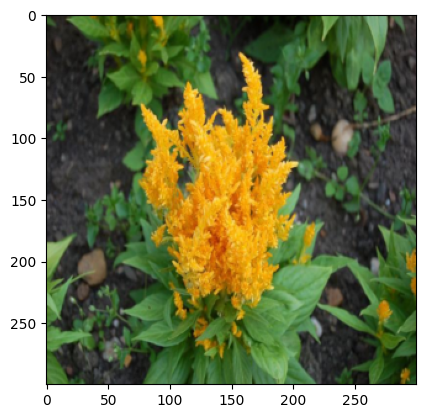

Label: 26
Feature batch shape: torch.Size([32, 3, 300, 300])
Labels batch shape: torch.Size([32])


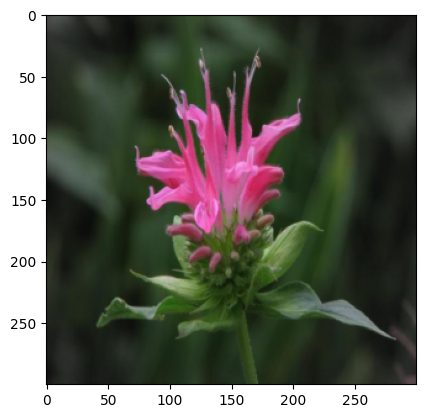

Label: 91


In [ ]:
# get the training data from the Flowers102 dataset
# This dataset is used to get the mean and standard deviation of the dataset
initial_train_data = datasets.Flowers102(root = "data", split = 'train', 
                                    download = True, transform = training_initial_tranforms)
initial_train_loader = torch.utils.data.DataLoader(dataset = initial_train_data, batch_size=32, shuffle=True)

# Displays 5 of the training images
for i in range(5):
  train_features, train_labels = next(iter(initial_train_loader))
  print(f"Feature batch shape: {train_features.size()}")
  print(f"Labels batch shape: {train_labels.size()}")
  img = train_features[0].numpy().transpose((1, 2, 0))
  label = train_labels[0]
  plt.imshow(img)
  plt.show()
  print(f"Label: {label}")

##Defines a function which calulates the mean and standard deviation of the training set

In [ ]:
# This function gives an approximation of the mean and standard deviation of the dataset
# This has been heavily inspired by code shown in https://youtu.be/y6IEcEBRZks

def get_mean_and_std(loader):
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  for data, _ in loader:
    channels_sum += torch.mean(data, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
    num_batches += 1
  mean = channels_sum / num_batches
  std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
  return mean, std

# get the mean and standard deviation of the dataset
mean, std = get_mean_and_std(initial_train_loader)


## Defines different transformation sequences

In [ ]:
flips_and_rotations_and_colour_augmentation1 = transforms.Compose([transforms.Resize(image_size), # resize the images
    transforms.RandomRotation(35), # randomly rotate the image by 30 degrees
    transforms.RandomHorizontalFlip(0.4), # randomly flip the image horizontally
    transforms.ColorJitter(brightness=(0.5, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2)), 
    transforms.ToTensor(), transforms.Normalize(mean, std), transforms.RandomErasing(p=0.4)
])

flips_and_rotations_and_colour_augmentation2 = transforms.Compose([transforms.Resize(preimage_size),
                                                                   transforms.RandomRotation(35),
                                                                    transforms.CenterCrop(image_size), # resize the images
    transforms.RandomHorizontalFlip(0.6), # randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.6, contrast=0.7, saturation=1.5), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.4)
])


crops = transforms.Compose([transforms.Resize(image_size),
                            transforms.RandomRotation(10),
                            transforms.CenterCrop(image_size),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std),
                            transforms.RandomErasing(p=0.4)
])

everything = transforms.Compose([transforms.Resize(preimage_size),
                                transforms.RandomRotation(25),
                                transforms.CenterCrop(image_size),
                                 transforms.RandomHorizontalFlip(0.5), # randomly flip the image horizontally
                                 transforms.RandomVerticalFlip(0.3),
                                 transforms.ColorJitter(brightness=(0.2, 1.2), contrast=(0.2, 1.5), saturation=1.5), # adjusts the colour
                                 transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), # blurs the image
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std),
                                 transforms.RandomErasing(p=0.4, scale=(0.02, 0.15))]) # randomly adds a black box to the image


# Defines the transforms for the test dataset
test_transform = transforms.Compose([
    transforms.Resize(image_size[0]), # resize the images (while keeping the aspect ratio)
    transforms.CenterCrop(image_size[0]), # crops to a square (using the shortest side)
    transforms.ToTensor(), # converts the image to a tensor
    transforms.Normalize(mean, std) # normalise the images
]) 

In [ ]:
# Applies the defined transformation sequences to the training dataset
training_data_resized = datasets.Flowers102(root = "data", split = 'train', 
                                    download = True, transform = transforms.Compose([transforms.Resize(image_size), 
                                                                                     transforms.ToTensor(), 
                                                                                     transforms.Normalize(mean, std)]))

training_data_resized_with_flips_and_rotations_and_colour_augmentation1 = datasets.Flowers102(root = "data", split = 'train',
                                    download = True, transform = flips_and_rotations_and_colour_augmentation1)
training_data_resized_with_flips_and_rotations_and_colour_augmentation2 = datasets.Flowers102(root = "data", split = 'train',
                                    download = True, transform = flips_and_rotations_and_colour_augmentation2)
training_data_cropped_with_flips_and_rotations = datasets.Flowers102(root = "data", split = 'train',
                                    download = True, transform = crops)
training_data_everything = datasets.Flowers102(root = "data", split = 'train',
                                    download = True, transform = everything)

# Concatenate all the augmented training data together so that there are more images to train on
final_training_data = torch.utils.data.ConcatDataset([training_data_resized, 
                                                      training_data_resized_with_flips_and_rotations_and_colour_augmentation1,
                                                      training_data_resized_with_flips_and_rotations_and_colour_augmentation2,
                                                      training_data_cropped_with_flips_and_rotations,
                                                      training_data_everything,
                                                      ])


# Get the test and validation data from the Flowers102 dataset
test_data = datasets.Flowers102(root = "data", split = 'test', download = True, transform = test_transform)
validation_data = datasets.Flowers102(root = "data", split = 'val', download = True, transform = test_transform)

In [ ]:
# Show the shape of the image tensors 
print(final_training_data[0][0].shape)
print(test_data[0][0].shape)
print(validation_data[0][0].shape)

torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])


In [ ]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(final_training_data, batch_size=batch_size, shuffle=True, collate_fn=None)
valid_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, collate_fn=None)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=None)
print(test_dataloader)
print(train_dataloader)
print(valid_dataloader)

for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 200, 200])
Shape of y: torch.Size([32]) torch.int64


## Display 10 augmented training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


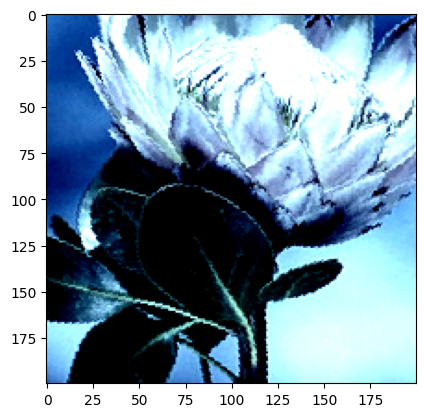

Label: 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


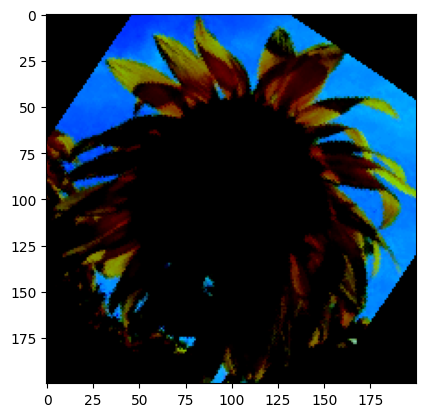

Label: 53


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


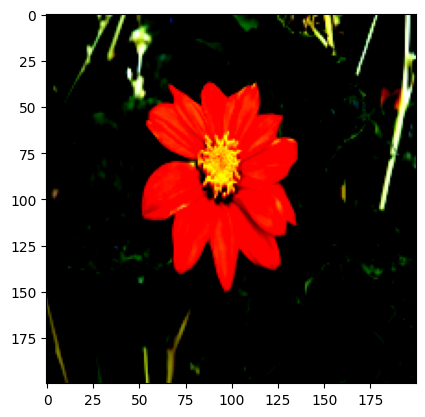

Label: 58


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


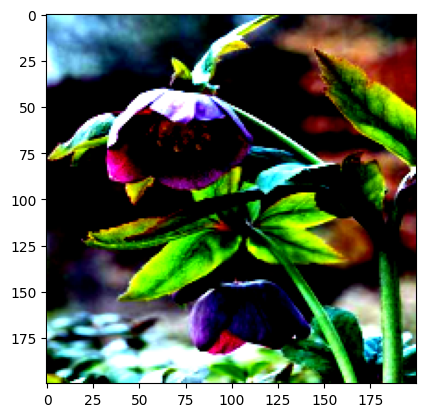

Label: 39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


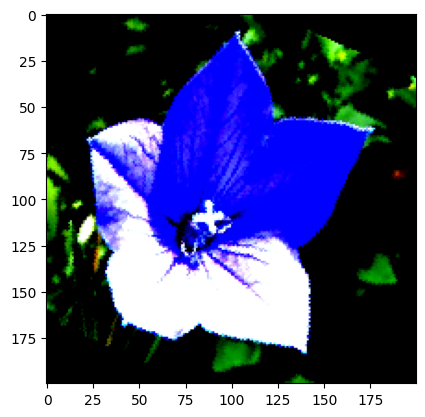

Label: 18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


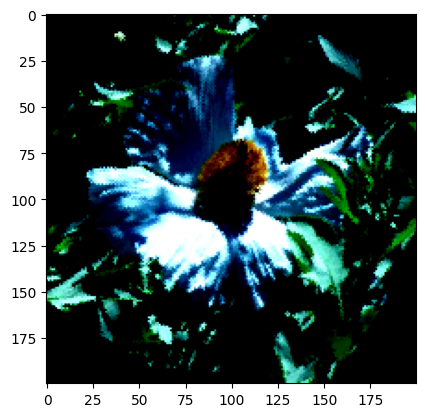

Label: 69


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


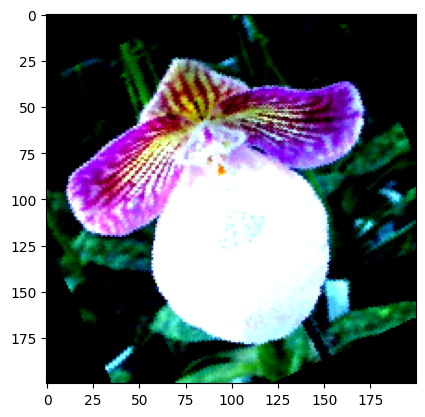

Label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


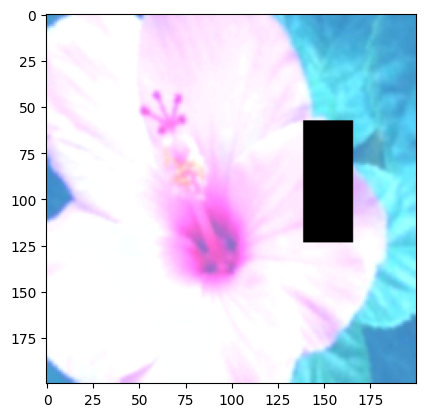

Label: 82


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


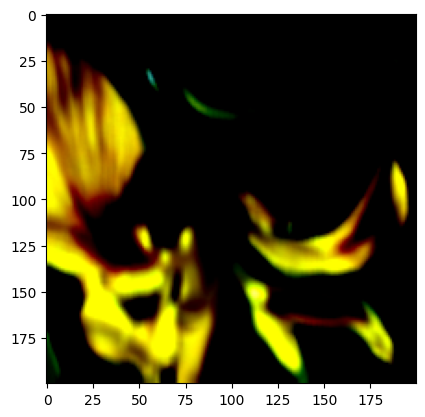

Label: 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


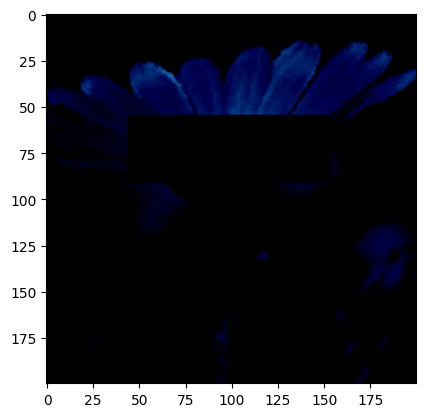

Label: 4


In [ ]:
#Display image and label. This code has been inspired by code from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
for i in range(10):
  train_features, train_labels = next(iter(train_dataloader))
  print(f"Feature batch shape: {train_features.size()}")
  print(f"Labels batch shape: {train_labels.size()}")
  img = train_features[0].numpy().transpose((1, 2, 0))
  label = train_labels[0]
  plt.imshow(img)
  plt.show()
  print(f"Label: {label}")

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Defines the neural network structure

In [ ]:
# Define neural network model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            # input: 32 x 3 x 200 x 200
            nn.Conv2d(3, 32, 5, stride=1, padding=1, bias=False), # 3 input channels, 32 output channels (num of filters that will be applied to the input image), 
            # 5x5 kernel (size of filter), stride of 1, padding of 1 (adds a 0 padding around the image so that the output image is the same size as the input image)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # output: 32 x 32 x 200 x 200
            nn.MaxPool2d(2, 2), # 2x2 kernel, stride of 2
            nn.Conv2d(32, 64, 5, stride=1, padding=1, bias=False), # 32 input channels, 64 output channels, 5x5 kernel
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # output: 32 x 64 x 50 x 50

            nn.Conv2d(64, 128, 5, stride=1, padding=1, bias=False), # 64 input channels, 128 output channels, 5x5 kernel
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # output: 32 x 128 x 25 x 25
            nn.Conv2d(128, 164, 5, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(164),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # output: 32 x 164 x 23 x 23

            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(164 * 10 * 10, 150), # 80 * 8 * 8 input features, 150 output features
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Linear(150, 120), # 150 input features, 120 output features
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(120, 102) # 120 input features, 102 output features (because there are 102 flower classes)
        )
        
    def forward(self, x):
        return self.network(x)

model = ConvNeuralNetwork().to(device)
print(model)

ConvNeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 164, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(164, eps=1e-0

## Defines the loss function and optimiser

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser1 = torch.optim.SGD(model.parameters(), lr=9e-3, momentum=0.9)

## Defines the learning rate scheduler

In [ ]:
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser1, factor=0.1, patience=3, verbose=True, threshold=0.0001, threshold_mode='abs')

## Defines the train function

In [ ]:
def train(model, training_data, validation_data, loss_fn, optimiser, scheduler, num_epochs):
    # running_loss = 0.0
    # running_correct = 0.0
    for epoch in range(num_epochs):
      model.train()
      total = 0
      size = len(training_data.dataset)
      losses = []
      print("Epoch:", epoch + 1)
      for batch, (X, y) in enumerate(training_data):
          X, y = X.to(device), y.to(device)
          total += y.size(0)
          
          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)
          
          # Backpropagation
          optimiser.zero_grad()
          loss.backward()
          optimiser.step()
          
          # running_loss += loss.item()
          _, predicted = torch.max(pred.data, 1)
          # running_correct += (predicted == y).sum().item()
          loss, current = loss.item(), (batch + 1) * len(X)
          losses.append(loss)
          
      mean_loss = sum(losses)/len(losses)
      scheduler.step(mean_loss)      
      # epoch_loss = running_loss / len(training_data)
      # epoch_acc = 100 * (running_correct / total)
      
      # print(f"Running training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")
      # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      print("Training error:")
      evaluation(model, training_data)
      print("Validation error:")
      evaluation(model, validation_data)
      torch.save(model.state_dict(), 'model_weights.pth')
      
    
    print("Completed Training")
    print("Test error:")
    evaluation(model, test_dataloader)
    return model

## Defines the evaluation function

In [ ]:
def evaluation(model, test_data):
    model.eval()
    size = len(test_data.dataset)
    num_batches = len(test_data)
    predicted_correctly_on_epoch = 0
    # total = 0
    loss = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            # total += y.size(0)
            
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # _, predicted = torch.max(pred.data, 1)
            predicted_correctly_on_epoch += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    predicted_correctly_on_epoch /= size
    print(f"Accuracy: {(100*predicted_correctly_on_epoch):>0.1f}%, Avg loss: {loss:>8f} \n")

In [ ]:
torch.cuda.empty_cache()

## Trains the neural network

In [ ]:
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
train(model, train_dataloader, valid_dataloader, loss_fn, optimiser1, scheduler1, 75)

Epoch: 1
Training error:
Accuracy: 13.2%, Avg loss: 3.792121 

Validation error:
Accuracy: 11.7%, Avg loss: 3.783438 

Epoch: 2
Training error:
Accuracy: 23.5%, Avg loss: 3.160023 

Validation error:
Accuracy: 19.8%, Avg loss: 3.274443 

Epoch: 3
Training error:
Accuracy: 34.2%, Avg loss: 2.743799 

Validation error:
Accuracy: 26.7%, Avg loss: 3.031208 

Epoch: 4
Training error:
Accuracy: 37.4%, Avg loss: 2.479882 

Validation error:
Accuracy: 25.5%, Avg loss: 3.001766 

Epoch: 5
Training error:
Accuracy: 45.6%, Avg loss: 2.155981 

Validation error:
Accuracy: 31.6%, Avg loss: 2.791645 

Epoch: 6
Training error:
Accuracy: 53.7%, Avg loss: 1.890858 

Validation error:
Accuracy: 32.9%, Avg loss: 2.713984 

Epoch: 7
Training error:
Accuracy: 59.2%, Avg loss: 1.645974 

Validation error:
Accuracy: 34.9%, Avg loss: 2.669785 

Epoch: 8
Training error:
Accuracy: 63.3%, Avg loss: 1.476321 

Validation error:
Accuracy: 36.3%, Avg loss: 2.609686 

Epoch: 9
Training error:
Accuracy: 66.4%, Avg lo

ConvNeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 164, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(164, eps=1e-0

In [ ]:
train(model, train_dataloader, valid_dataloader, loss_fn, optimiser1, scheduler1, 10) # ran for 10 more epochs

Epoch: 1
Epoch 00076: reducing learning rate of group 0 to 9.0000e-08.
Training error:
Accuracy: 95.6%, Avg loss: 0.192041 

Validation error:
Accuracy: 52.5%, Avg loss: 2.299257 

Epoch: 2
Training error:
Accuracy: 95.7%, Avg loss: 0.179502 

Validation error:
Accuracy: 52.2%, Avg loss: 2.341313 

Epoch: 3
Training error:
Accuracy: 95.2%, Avg loss: 0.190759 

Validation error:
Accuracy: 52.3%, Avg loss: 2.319569 

Epoch: 4
Training error:
Accuracy: 95.7%, Avg loss: 0.176899 

Validation error:
Accuracy: 52.6%, Avg loss: 2.329920 

Epoch: 5
Epoch 00080: reducing learning rate of group 0 to 9.0000e-09.
Training error:
Accuracy: 96.0%, Avg loss: 0.174633 

Validation error:
Accuracy: 53.8%, Avg loss: 2.304543 

Epoch: 6
Training error:
Accuracy: 95.8%, Avg loss: 0.171122 

Validation error:
Accuracy: 52.2%, Avg loss: 2.339626 

Epoch: 7
Training error:
Accuracy: 95.7%, Avg loss: 0.178941 

Validation error:
Accuracy: 52.6%, Avg loss: 2.325689 

Epoch: 8
Training error:
Accuracy: 95.5%, A

ConvNeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 164, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(164, eps=1e-0

In [ ]:
# torch.save(model, "entire_model.pth") # saves the model

## Code which declares the model then loads its weights

In [ ]:
model_loaded_from_saved_weights = ConvNeuralNetwork().to(device)
model_loaded_from_saved_weights.load_state_dict(torch.load("model_weights.pth"))

<All keys matched successfully>

In [ ]:
# Evaluate the loaded model against the test data
evaluation(model_loaded_from_saved_weights, test_dataloader)

Accuracy: 48.8%, Avg loss: 2.704833 



## Code which loads the entire model

In [ ]:
entire_model_loaded = torch.load("entire_model.pth")

In [ ]:
# Evaluate the loaded model against the test data
evaluation(entire_model_loaded, test_dataloader)

Accuracy: 48.8%, Avg loss: 2.704833 

